In [1]:
# This will be the next generation of model. The model will aim to include all relief pitchers as well as standardising the data.
# Features: Batters: Pitchers
# Version: 1.0

In [2]:
import import_ipynb
from sklearn import svm
from pymysql import connect
from sys import path
from pathlib import Path
path.append('../../../') 
from BaseballAnalytics.bin.app_utils.queries_vTwo import Queries as Qu_VTwo
from BaseballAnalytics.bin.app_utils.consolidation.consolidating_features import Feature_Consolidater
from BaseballAnalytics.bin.app_utils.queries import Queries as Qu
from BaseballAnalytics.bin.app_utils.common_help import Log_Helper
from pickle import dump, load

In [3]:
# Connect to the database.
data_locs = Path(r"C:\Users\micha\Documents\GitHub\BaseballAnalytics\source_data\model_data\model_v2")      # The location of the past queries.
conn = connect(host="localhost", user="root", passwd="praquplDop#odlg73h?c", db="baseball_stats_db")
qu_vTwo = Qu_VTwo(conn)
qu = Qu(conn)

In [4]:
# Get all the game ids with the relevent information attributed to those id. Ensure to get games past May 15.
# The games are returned from earliest played to most recent.
game_outcomes = qu_vTwo.get_game_outcomes(day=15, month=5)            
game_outcomes = game_outcomes[200:]
game_outcomes[0:5]

[('LAN199005020', 1990, 2, 5, 6, 2, 'LAN', 'PIT', 0),
 ('MON199005020', 1990, 2, 5, 1, 8, 'MON', 'ATL', 1),
 ('NYA199005020', 1990, 2, 5, 0, 2, 'NYA', 'OAK', 1),
 ('NYN199005020', 1990, 2, 5, 5, 0, 'NYN', 'CIN', 0),
 ('PHI199005020', 1990, 2, 5, 14, 4, 'PHI', 'HOU', 0)]

In [5]:
# Fetch the players, pitchers, and offensive features from all the games.
pitchers_pickle = 'game_pitchers.pickle'
all_pitchers = qu_vTwo.get_pitchers_in_all_games(data_locs / pitchers_pickle)
qu_vTwo.unpack_pitchers(all_pitchers)

An Event ['langm001', '0ANA199704020']
Num Events 46
Num Games 162
Num Years 23
Num Teams 33


In [6]:
# Gather all the relief pitchers. -- POSSIBLE EXCEPTION (NOT ALL GAMES INCLUDED, GAMES MAY BE MISSING DUE TO COMPLETE GAMES)
relief_pitchers = qu_vTwo.get_relief_pitchers(all_pitchers, 25)
print("Games accounted for: {}".format(len(relief_pitchers)))
for game in relief_pitchers:
    print(game)
    print(relief_pitchers[game])
    break

The number of relievers to contian: 3
Games accounted for: 69649
ANA199704020
{'ANA': ['may-d002', 'perct001', 'jamem001'], 'BOS': ['henrb001', 'mahop001', 'sloch001']}


In [7]:
# Gather all the starting pitchers.
starting_pitchers = qu_vTwo.get_starting_pitchers(all_pitchers)
print("Games accounted for: {}".format(len(starting_pitchers)))
for game in starting_pitchers:
    print(game)
    print(starting_pitchers[game])
    break

Games accounted for: 70101
ANA199704020
{'ANA': 'langm001', 'BOS': 'gordt001'}


In [8]:
# Gather all the pitching features from the database.
pitching_feat_pickle = 'raw_pitching_features.pickle'
pitching_features = qu_vTwo.get_all_pitching_features(data_locs / pitching_feat_pickle)
for player_id in pitching_features:
    print(player_id)
    for i, game in enumerate(pitching_features[player_id]):
        print(game)
        if i > 1: break
    break

ackej001
['TEX199004090', 1.0, 2.02, 0.0]
['TOR199004120', 1.5, 1.261, 0.0]
['KCA199004150', 1.333, 2.861, 0.667]


In [9]:
# Acquire all the batters from the database.
batters_pickle = 'game_players.pickle'
all_batters = qu_vTwo.get_batters(data_locs / batters_pickle)
for game_id in all_batters:
    print(game_id)
    for i, event in enumerate(all_batters[game_id]):
        print(event)
        if i > 6: break
    break

ANA199704020
['garcn001', 0, '0ANA199704020']
['pembr001', 0, '10ANA199704020']
['haseb001', 0, '11ANA199704020']
['macks001', 0, '12ANA199704020']
['holld001', 1, '13ANA199704020']
['andeg001', 1, '14ANA199704020']
['murre001', 1, '15ANA199704020']
['leyrj001', 1, '16ANA199704020']


In [10]:
# Acquire all the batters features from the database.
offensive_feat_pickle = 'raw_offensive_features.pickle'
offensive_features = qu_vTwo.get_all_offensive_features(data_locs / offensive_feat_pickle)
for player_id in offensive_features:
    print(player_id)
    for i, game in enumerate(offensive_features[player_id]):
        print(game)
        if i > 1: break
    break

bainh001
['TEX199004090', 0.25, 1.0]
['TOR199004100', 0.25, 0.625]
['TOR199004110', 0.5, 0.625]


In [11]:
# Gather all the features from every game and separate them into X and Y.
features_pickle = 'game_features.pickle'
lh = Log_Helper()
X = []
Y = []
fc = Feature_Consolidater()
num_games = len(game_outcomes)
lh.print_progress_bar(0, num_games, prefix = 'Progress:', suffix = 'Complete', length = 50)    # Initial call to print 0% progress
for num, game_stats in enumerate(game_outcomes):
    try:
        X.append(fc.get_game_features_normalise(all_batters, offensive_features, all_pitchers, starting_pitchers, relief_pitchers, pitching_features, game_stats))
        Y.append(game_stats[8])
    except Exception:
        print("An error as occurred at {}".format(game_stats[0]))
    lh.print_progress_bar(num + 1, num_games, prefix = 'Progress:', suffix = 'Complete', length = 50)
with open(data_locs / features_pickle, 'wb') as f:
    dump(X, f)
#with open(data_locs / features_pickle, 'rb') as f: X = load(f)

An error as occurred at LAN199007270
An error as occurred at PIT199010030
An error as occurred at SDN199105110
An error as occurred at PHI199109030
An error as occurred at SDN199506220
An error as occurred at MON199506240
An error as occurred at SDN199509010
An error as occurred at SFN199604170
An error as occurred at SDN199707030
An error as occurred at PHI199708252
An error as occurred at COL199709280
An error as occurred at NYN199809070
An error as occurred at ATL200004210
An error as occurred at NYN200209032
An error as occurred at FLO200306210
An error as occurred at ARI200405140
An error as occurred at PHI200406290
An error as occurred at SFN200606280
An error as occurred at CHN200609040
Progress: |||||||||||||||||||||||||||||----------------------| 56.4% CompleteAn error as occurred at SFN200706220
An error as occurred at SDN200707070
An error as occurred at COL200807040
An error as occurred at WAS200809240
An error as occurred at CIN200905230
An error as occurred at SFN20090612

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\micha\AppData\Local\Pro

In [13]:
# Split the data for modelling.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y)

In [14]:
sm = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
sm.score(X_test, y_test)

0.5290237467018469

In [15]:
rf = RandomForestClassifier(max_depth=15, random_state=0).fit(X_train, y_train)
rf.score(X_test, y_test)

0.5443474731073675

In [16]:
lr = LogisticRegression(max_iter=5000).fit(X_train, y_train)
print(lr.score(X_test, y_test))
print(lr.coef_, lr.intercept_)

0.5571341587172721
[[ 1.08923148e-01 -1.14692866e+00 -6.77550671e-01 -1.33526149e+00
  -8.38026308e-01 -3.04195501e-01 -1.69828347e+00 -2.47336072e-01
  -4.03840093e-01  1.04740657e+00 -2.67208746e-01  3.78905519e-01
   1.34148823e+00  2.09710934e+00  1.01428574e+00 -1.19685459e-03
   6.99226132e-01  2.02253036e-01 -6.88267297e-01 -5.38119103e-01
  -6.77007918e-01 -2.59640342e-01 -5.79847177e-01 -1.13702192e-01
   7.79557302e-01  6.15559159e-01 -1.05197362e+00  3.80111543e-01
   2.82778305e-01  3.18363636e-01  4.51603914e-01 -4.22996435e-01
  -2.20490099e-02  7.44519228e-01  8.30791433e-02  6.67800717e-01
  -1.23461509e+00  9.50032025e-02 -5.37282372e-02 -2.96072689e-01
   1.13937627e+00  3.60377407e-01  4.40046675e-02 -8.45756789e-02
   5.98376582e-01  5.62950214e-02  9.23518931e-02  1.80572658e-01
  -6.04931082e-01  5.17010087e-02 -1.32725630e-01 -2.71870594e-01
   6.47843465e-01  4.84876871e-02  3.22164093e-01  2.96377883e-01
  -7.44894416e-01 -3.37368286e-01 -3.18964891e-01  5.6124

In [17]:
mlp = MLPClassifier(random_state=1, max_iter=2000).fit(X_train, y_train)
mlp.score(X_test, y_test)

0.5303430079155673

Confusion matrix, without normalization
[[3860 1353]
 [3011 1630]]
Normalized confusion matrix
[[0.74045655 0.25954345]
 [0.64878259 0.35121741]]


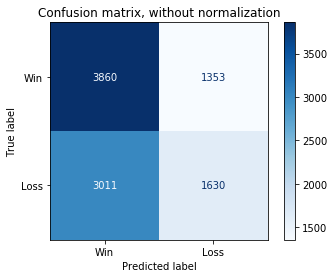

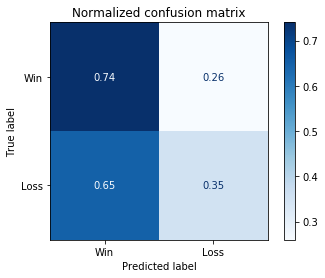

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['Win', 'Loss'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [19]:
# Use cross validation to get a better idea of the models success.
from sklearn.model_selection import cross_val_score
lr_cv = LogisticRegression(max_iter=2000)
cv_scores = cross_val_score(lr_cv, X, Y, cv=5)
print(cv_scores)

[0.53904704 0.55754301 0.55213883 0.54921215 0.55278983]


In [20]:
rf_cv = RandomForestClassifier(max_depth=15, random_state=0)
cv_scores = cross_val_score(rf_cv, X, Y, cv=5)
print(cv_scores)

[0.54011265 0.55229106 0.54802862 0.54692852 0.54479714]


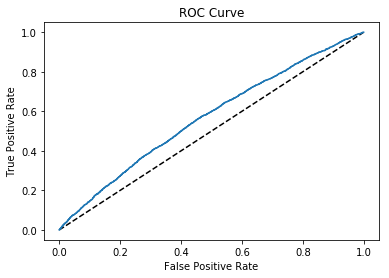

In [21]:
# Build an ROC for the Logistical Regression
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()